In [2]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import SymLogNorm
import h5py
from tqdm import tqdm


In [184]:
basePath = 'sims.TNG/TNG100-1/output'
snap     = 99
halo_ID  = 172650 #239993 #172650 #239993 
stars_subfind_IDs = np.loadtxt(f'progenitorID_subhalo{halo_ID}.txt', dtype=int)
stars_coord = il.snapshot.loadSubhalo(basePath,snap, halo_ID, 'stars', fields='Coordinates')

In [185]:
tree = il.sublink.loadTree(basePath,snap,halo_ID)
tree_main = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True)

In [186]:
N_subhalo_in_tree = tree['count']
ID_init           = tree['SubhaloID'][0]
all_subfind_IDs   = tree['SubfindID']
main_tree_IDs     = tree_main['SubhaloID'] - ID_init
all_tree_IDs      = tree['SubhaloID'] - ID_init

# Dictionnary to convert subfind IDs to tree IDs
subfind_to_tree_IDs = {all_subfind_IDs[i]: all_tree_IDs[i] for i in range(len(all_tree_IDs))}

# Get arguments of Subhalos who descendant is on the main branch excluding those already on the main branch
all_descendant_tree_IDs = tree['DescendantID'] - ID_init
all_descendant_tree_IDs[:len(main_tree_IDs)] = -1
arg_main_as_descendant = np.where( (0 <= all_descendant_tree_IDs) & (all_descendant_tree_IDs <= main_tree_IDs[-1]))[0]

In [187]:
### Change ProgenitorIDs of stars from SubfindID to TreeID ###
stars_ID = np.zeros_like(stars_subfind_IDs)
for index, i in enumerate(stars_subfind_IDs):
    stars_ID[index] = subfind_to_tree_IDs[i]

# Get the TreeIDs of all subhalos who's descendants are on the main branch
next_to_main_tree_IDs = all_tree_IDs[arg_main_as_descendant]

In [188]:
### Change Progenitor IDs of stars from Birth ID to Next to main branch subhalo ###
next_to_main_stars_ID = np.zeros_like(stars_subfind_IDs)
qty_stars_in_mask = []
mask_tree_ID = []
for index, i in enumerate(next_to_main_tree_IDs):
    if index == 0:
        mask_bot = 0 <= stars_ID 
        mask_top = stars_ID < next_to_main_tree_IDs[index]
        mask = mask_bot * mask_top
        next_to_main_stars_ID[mask] = 0
        mask_tree_ID.append(0)

    else:
        mask_bot = next_to_main_tree_IDs[index-1] <= stars_ID 
        mask_top = stars_ID < next_to_main_tree_IDs[index]
        mask = mask_bot * mask_top
        next_to_main_stars_ID[mask] = next_to_main_tree_IDs[index-1]
        mask_tree_ID.append(next_to_main_tree_IDs[index-1])

    qty_stars_in_mask.append(mask.sum())
    
mask_bot = next_to_main_tree_IDs[-1] <= stars_ID 
mask = mask_bot
qty_stars_in_mask.append(mask.sum())
next_to_main_stars_ID[mask] = next_to_main_tree_IDs[-1]
mask_tree_ID.append(next_to_main_tree_IDs[-1])

/tmp/ipykernel_3212/4031558645.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = plt.cm.get_cmap('tab20', 20).colors
/tmp/ipykernel_3212/4031558645.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_use,Y_use, s=0.5, alpha=0.3, c=tab20[index])


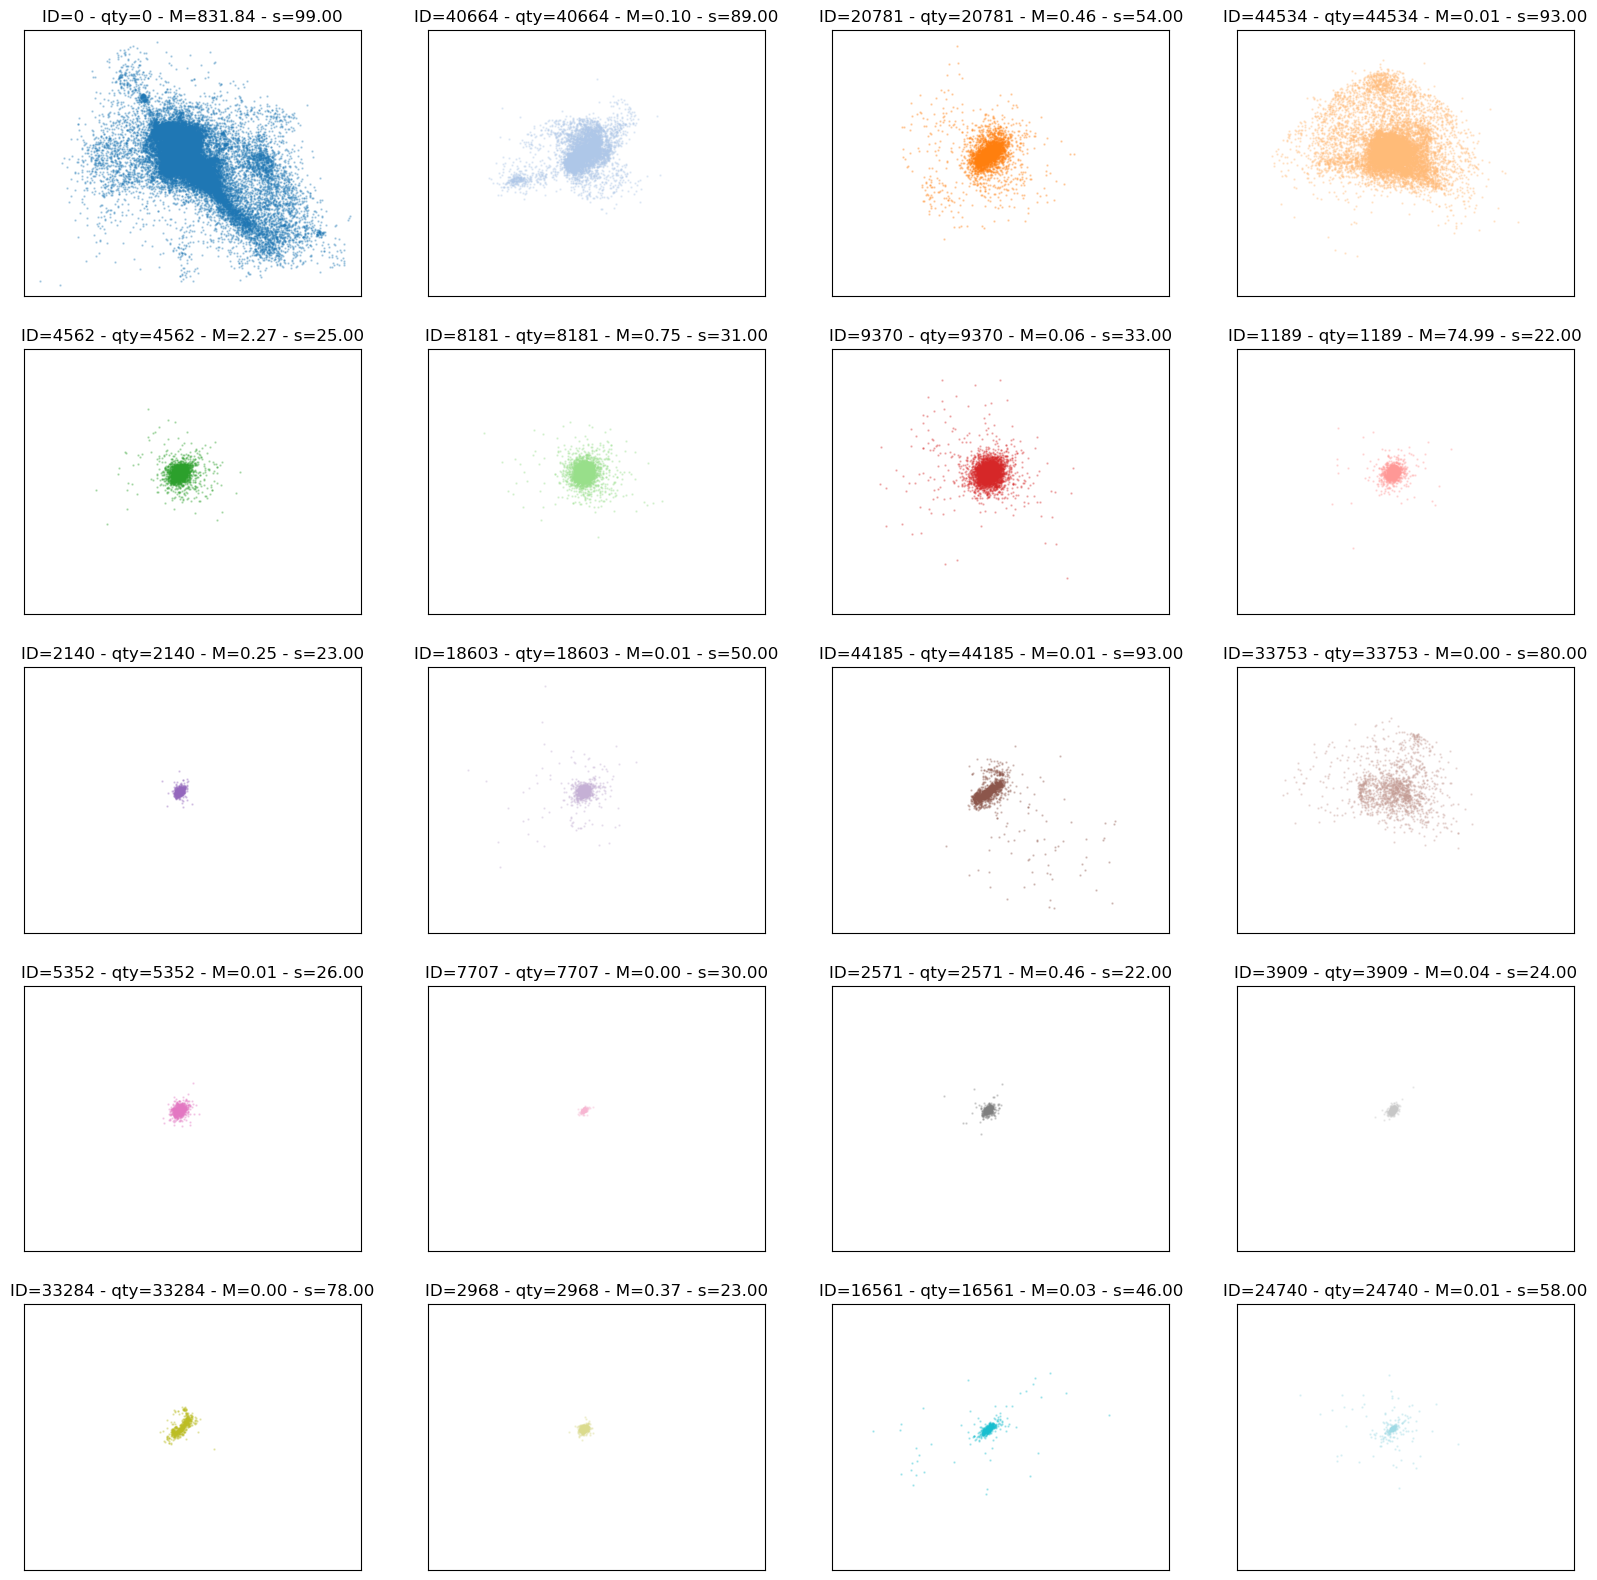

In [194]:
arg_top20_subhalo_most_stars = np.argsort(qty_stars_in_mask)[-20:][::-1]
tree_IDs_subhalo_most_stars = np.array(mask_tree_ID)[arg_top20_subhalo_most_stars]

subhalo_mass = tree['Mass']
snap = tree['SnapNum']

X = stars_coord[:,0]
Y = stars_coord[:,1]

tab20 = plt.cm.get_cmap('tab20', 20).colors
plt.figure(figsize=(20,20))
for index, i in enumerate(tree_IDs_subhalo_most_stars):
    plt.subplot(5,4,index+1)
    arg_use = np.where(next_to_main_stars_ID == i)
    X_use = X[arg_use]
    Y_use = Y[arg_use]
    plt.scatter(X_use,Y_use, s=0.5, alpha=0.3, c=tab20[index])
    # plt.hist2d(X_use,Y_use, bins=100, norm=SymLogNorm(1))
    plt.title(f'ID={i} - qty={tree_IDs_subhalo_most_stars[index]} - M={subhalo_mass[i]:.2f} - s={snap[i]:.2f}')
    plt.xlim([10300,11300])
    plt.ylim([36900,37600])
    plt.xticks([])
    plt.yticks([])
# plt.legend(loc='best')

/tmp/ipykernel_3212/340155528.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X,Y, s=0.5, alpha=0.3, c=tab20[index])


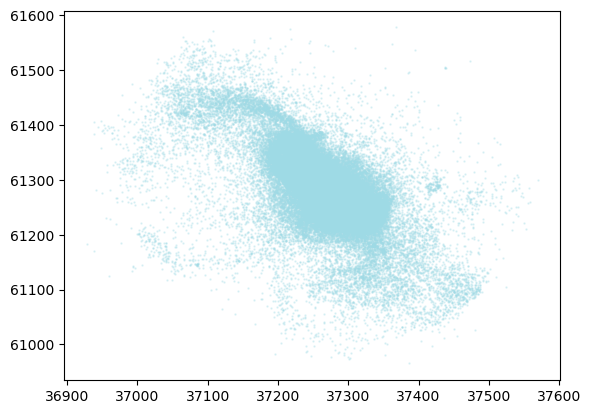

In [190]:
plt.scatter(X,Y, s=0.5, alpha=0.3, c=tab20[index])